In [29]:
import pytraj as pt
import pytraj.utils.progress
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import gc
import nglview as nv
import copy

# NGLVIEW Network Matrix Drawing Functions
These functions provide facilities to draw a network of residue-residue interactions
onto a 3D rendering of a corresponding protein.

Edge thicknesses are defined as the log of the absolute values of the matrix entries
while edge colors (and a corresponding colorbar if needed) are computed directly from the
given network.

In cases where only certain entries of the matrix are desired, these can be specified
with the "maskInds" parameter. If none is provided this will default to all finite entries of
the matrix (e.g. all entries where the value is numeric). For the radii (edge width) calculation
only non-zero entries will be considered.

The networks used to define edge color and edge radii need not be the same.

<B>Note: This notebook makes use of pytraj to help visualize the network</B>

In [24]:
def drawProtNetEdge(protStruc,resID1,resID2,ngViewOb,
                    frame=0,edgeColor=[.5,.5,.5],radius=1,
                    *shapeArgs,**shapeKwargs):
    crd1=pt.center_of_mass(protStruc,':%g@CA'%resID1)[frame]
    crd2=pt.center_of_mass(protStruc,':%g@CA'%resID2)[frame]
    
    
    resname1=protStruc.topology.residue(resID1-1).name
    resid1=protStruc.topology.residue(resID1-1).original_resid
    
    resname2=protStruc.topology.residue(resID2-1).name
    resid2=protStruc.topology.residue(resID2-1).original_resid
    edgeLabel='%s.%g-%s.%g (%g-%g)'%(
        resname1,resid1,resname2,resid2,
        resID1-1,resID2-2)
    
    return ngViewOb.shape.add_cylinder(
        list(crd1),list(crd2),edgeColor,radius,
        edgeLabel,
        *shapeArgs,**shapeKwargs)

def getNetworkEdgeColors(valMat,maskInds=None,
                         cmap=matplotlib.cm.get_cmap('viridis',1024),
                         cNorm=None,
                         baseColor=[0.,0.,0.]):
    if maskInds is None:
        nzInds=np.nonzero(np.isfinite(valMat))
    else:
        nzInds=maskInds
    
    if cNorm is None:
        vMin=np.min(valMat[nzInds])
        vMax=np.max(valMat[nzInds])
        norm=matplotlib.colors.Normalize(vmin=vMin,vmax=vMax)
    else:
        norm=cNorm
    
    tempCarray=cmap(norm(valMat[nzInds]).data)
    edgeColors=np.zeros((valMat.shape[0],valMat.shape[1],3))
    for ii in np.arange(3):
        edgeColors[:,:,ii]=baseColor[ii]
        edgeColors[:,:,ii][nzInds]=tempCarray[:,ii]
    return(edgeColors)

def drawEdgeColorBar(valMat,maskInds=None,
                     cmap=matplotlib.cm.get_cmap('viridis',1024),
                     cNorm=None,
                     ax=None,
                     label='Edge Color Scale',
                     orientation='horizontal',
                     verbose=False):
    if maskInds is None:
        nzInds=np.nonzero(np.isfinite(valMat))
    else:
        nzInds=maskInds
    
    tempCarray=cmap(valMat[nzInds])
    if verbose:
        print('vMin:',vMin,'vMax:',vMax)
    
    if cNorm is None:
        vMin=np.min(valMat[nzInds])
        vMax=np.max(valMat[nzInds])
        norm=matplotlib.colors.Normalize(vmin=vMin,vmax=vMax)
    else:
        norm=cNorm
    
    if ax is None:
        if orientation=='horizontal':
            fig = plt.figure(figsize=(16, 4))
            ax1 = fig.add_axes([0.3, 0.80, 0.4, 0.15])
        else:
            fig = plt.figure(figsize=(4, 16))
            ax1 = fig.add_axes([0.3, 0.10, 0.15, 0.4])
    else:
        ax1=ax
    cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation=orientation)
    cb1.set_label(label)
    plt.show()

def getCorrNetEdgeRadii(valMat,maskInds=None,
                        eMin=.0625,eMax=.75):
    if maskInds is None:
        nzInds=np.isfinite(valMat)*(valMat>0)
    else:
        nzInds=maskInds
        
    radiiMat=np.zeros(valMat.shape)
    radiiMat[nzInds]=np.log(np.abs(np.array(valMat)[nzInds]))
    rMin=np.min(radiiMat[nzInds])
    rMax=np.max(radiiMat[nzInds])
    rLinFun=lambda x: (x-rMin)/(rMax-rMin)
    rMap=lambda x:(eMax-eMin)*rLinFun(x)+eMin
    radiiMat[nzInds]=rMap(np.array(radiiMat[nzInds]))
    return(radiiMat)

def drawProtCorrMat(protStruc,corrMat,ngViewOb,
                    maskInds=None,
                    frame=0,colorsArray=None,radiiMat=None,
                    undirected=True):
    if edgeInds is None:
        nzInds=np.nonzero(corrMat)
    else:
        nzInds=maskInds
        
    edgeList=[]
    if not (radiiMat is None):
        radMat=radiiMat
    else:
        radMat=(np.abs(corrMat)>0)*.25
    if undirected:
        indArray=np.array([[ind[0],ind[1]] \
                            for ind in np.array([nzInds[0],nzInds[1]]).T \
                            if ind[0]<ind[1]])
    else:
        indArray=np.array([nzInds[0],nzInds[1]]).T
    for nzInd in indArray:
        if not (colorsArray is None):
            colorParm={'edgeColor':list(colorsArray[nzInd[0],nzInd[1],:])}
        else:
            colorParm={}
        edgeList.append(drawProtNetEdge(
            protStruc,nzInd[0]+1,nzInd[1]+1,
            ngViewOb,frame,radius=radMat[nzInd[0],nzInd[1]],
            **colorParm))
    return edgeList

# Example Network Rendering
This example plots significant differences in correlated motion matrices from a wild type and mutant variant
of the ALK2 protein. The resulting network is overlayed onto the wild type structure.

viewing "struc.pdb"
pytraj.Trajectory, 2 frames: 
Size: 0.000307 (GB)
<Topology: 6873 atoms, 435 residues, 2 mols, PBC with box type = ortho>
           
with correlation matrix "Test_Delta_Mat.dat" network overlay


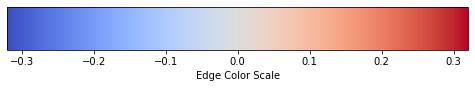

NGLWidget(count=2)

In [28]:
strucPath='struc.pdb'
matPath='Test_Delta_Mat.dat'
testStruc=pt.load(strucPath)
print ('viewing "%s"'%strucPath)
print (testStruc)
print ('with correlation matrix "%s" network overlay'%matPath)

view=nv.show_pytraj(testStruc)
testMat=np.loadtxt('Test_Delta_Mat.dat',skiprows=1)

nzInds=np.nonzero(testMat)

#Since the values we are visualizing represent differences
#We are using the 'coolwarm' colormap instead of the default
#'viridis'. This will help accentuate the extreme and midranges.
#Likewise, we are defining our norm explicitly here since we want to
#make sure that the center of our range corresponds to 0
colorArray=getNetworkEdgeColors(
    valMat=testMat,maskInds=nzInds,
    cmap=matplotlib.cm.get_cmap('coolwarm',1024),
    cNorm=matplotlib.colors.Normalize(
        vmin=-np.max(np.abs(testMat)),vmax=np.max(np.abs(testMat))),
    baseColor=[0.,0.,0.])

drawEdgeColorBar(
    valMat=testMat,maskInds=nzInds,
    cmap=matplotlib.cm.get_cmap('coolwarm',1024),
    cNorm=matplotlib.colors.Normalize(
        vmin=-np.max(np.abs(testMat)),vmax=np.max(np.abs(testMat))),
    ax=None,
    label='Edge Color Scale',
    orientation='horizontal',
    verbose=False)

edgeRadiiMat=getCorrNetEdgeRadii(
    valMat=testMat,maskInds=nzInds,
    eMin=.0625,eMax=.5625)

corrMatEdges=drawProtCorrMat(testStruc[:1],testMat,view,
                             colorsArray=colorArray,
                             radiiMat=edgeRadiiMat)

view

In [13]:
?matplotlib.colors.Normalize